In [ ]:
# from google.colab import files
# from google.colab import drive

# drive.mount('/content/drive')

Mounted at /content/drive


# Ingeniería de datos

## Importando datos SAMUR

In [ ]:
import pandas as pd
import numpy as np
import datetime as datetime
import requests
from bs4 import BeautifulSoup
import re
import seaborn as sns
import matplotlib.pyplot as plt

#importando datos
data= pd.read_csv('./activaciones_samur_2023.csv',delimiter=";")


#Especificando el tipo de datos para cada columna

data[['Mes','Código','Distrito','Hospital']]=data[['Mes','Código','Distrito','Hospital']].astype(str)
data[['Año']]=data[['Año']].astype(int)
data['Hora Solicitud']=pd.to_datetime(data['Hora Solicitud'],format= '%H:%M:%S')
data['Hora Intervención']=pd.to_datetime(data['Hora Intervención'], format= '%H:%M:%S')

#Cambiando las variables Mes y Distrito a numéricas

meses_dict = {
    'ENERO': 1,
    'FEBRERO': 2,
    'MARZO': 3,
    'ABRIL': 4,
    'MAYO': 5,
    'JUNIO': 6,
    'JULIO': 7,
    'AGOSTO': 8,
    'SEPTIEMBRE': 9,
    'OCTUBRE': 10,
    'NOVIEMBRE': 11,
    'DICIEMBRE': 12
}

distritos_diccionario = {
    'CENTRO': 1,
    'ARGANZUELA': 2,
    'RETIRO': 3,
    'SALAMANCA': 4,
    'CHAMARTIN': 5,
    'TETUAN': 6,
    'CHAMBERI': 7,
    'FUENCARRAL': 8,
    'MONCLOA': 9,
    'LATINA': 10,
    'CARABANCHEL': 11,
    'USERA': 12,
    'VALLECAS PTE.': 13,
    'MORATALAZ': 14,
    'CIUDAD LINEAL': 15,
    'HORTALEZA': 16,
    'VILLAVERDE': 17,
    'VILLA DE VALLECAS': 18,
    'VICALVARO': 19,
    'SAN BLAS': 20,
    'BARAJAS': 21,

}

data['Mes']=data['Mes'].map(meses_dict)
data['Mes_intervencion']=data['Mes']
data['No_Distrito']=data['Distrito'].map(distritos_diccionario)




In [2]:
#limpiando registros en blanco en las columnas de horas de solicitud e intervencion
data.dropna (subset=['Hora Solicitud', 'Hora Intervención'], inplace= True)
data=data.reset_index(drop=True)

#
data['Dia_solicitud']=1
data['Dia_intervencion']=1

#comparando las solicitudes para determinar el día
for i in range(1, len(data)):
    if data.loc[i,'Mes'] !=data.loc[i-1,'Mes']: # si el mes en i es diferente del anterior ( primer dia del mes )
        data.loc[i,'Dia_solicitud']=1
    else :
        if data.loc[i,'Hora Solicitud']>=data.loc[i-1,'Hora Solicitud']: # si la hora en i  es mayor que la anterior (mismo dia del registro anterior i-1)
            data.loc[i,'Dia_solicitud']= data.loc[i-1,'Dia_solicitud']
        else:        # si la hora en i es menor que la anterios  (nuevo dia    dia en registro(i-1) + 1)
           data.loc[i,'Dia_solicitud']=data.loc[i-1,'Dia_solicitud']+1



#Comparando las horas para determinar el dia partiendo de la intervencion
mes_dias = data.groupby('Mes')['Dia_solicitud'].max()
mes_dias = mes_dias.to_dict()

for i in range(1, len(data)):
    if data.loc[i,'Hora Intervención']< data.loc[i,'Hora Solicitud']:
      if (data.loc[i,'Dia_solicitud']+1)<=mes_dias.get(data.loc[i,'Mes']):
       data.loc[i,'Dia_intervencion']=data.loc[i,'Dia_solicitud']+1
      else :  data.loc[i,['Dia_intervencion', 'Mes_intervencion']]= [1,data.loc[i,'Mes']+1 ]
    else : data.loc[i,'Dia_intervencion']=data.loc[i,'Dia_solicitud']

data= data.loc[data['Mes_intervencion']!= 13]

#Convirtiendo las columnas de hora a tipo time

data['Hora Solicitud'] = data['Hora Solicitud'].dt.time
data['Hora Intervención'] = data['Hora Intervención'].dt.time


#convirtiendo las columnas indicadas en string para luego concatenar y convertirlas en una variable tipo datetime
data[['Año', 'Mes_intervencion','Mes', 'Dia_solicitud','Dia_intervencion']]=data[['Año','Mes_intervencion','Mes', 'Dia_solicitud','Dia_intervencion']].astype(str)

data['Fecha_Solicitud'] = data['Año']+'-'+ data['Mes']+'-'+data['Dia_solicitud']+' '+data['Hora Solicitud'].astype(str)
data['Fecha_Solicitud']=pd.to_datetime(data['Fecha_Solicitud'], format='%Y-%m-%d %H:%M:%S')

data['Fecha_Intervencion'] = data['Año']+'-'+ data['Mes_intervencion']+'-'+data['Dia_intervencion']+' '+data['Hora Intervención'].astype(str)
data['Fecha_Intervencion']=pd.to_datetime(data['Fecha_Intervencion'], format='%Y-%m-%d %H:%M:%S')

#sacando el tiempo de respuesta de las solicitudes
data['Tiempo_respuesta']=(data['Fecha_Intervencion']-data['Fecha_Solicitud']).dt.total_seconds()/60

#Creando variables binarias adicionales para los meses y trimestres a partir de la Fecha de solicitud
data['trimestre']= data['Fecha_Solicitud'].dt.quarter

#Creando la variable de dias festivos
dias_feriados_2023= ['2023-01-06',
    '2023-03-20',
    '2023-04-06',
    '2023-04-07',
    '2023-05-01',
    '2023-05-02',
    '2023-08-15',
    '2023-11-09',
    '2023-12-06',
    '2023-12-08',
    '2023-12-25',
    '2023-05-15',
    '2023-11-09'
]

data['dias_feriados_2023']=data['Fecha_Solicitud'].dt.date.astype(str).apply(lambda x: 1 if x in dias_feriados_2023 else 0)

#Creando una variable saber si es fin de semana o no
data['fin_de_semana'] = (data['Fecha_Solicitud'].dt.dayofweek >= 5).astype(int)

#Creando la variable dias de semana
data['dias_semana']=data['Fecha_Solicitud'].dt.day_name()

#Creando la variable hora
data['hora']=data['Fecha_Solicitud'].dt.hour

#Creando la variable Mes de solicitud
data['Mes_solicitud']=data['Fecha_Solicitud'].dt.month

#Categorizando las razones de emergencias que se encuentan en la columna de código
#dont forget SVB= soporte vital básico
import re
data['Código']=data['Código'].str.lower()



#Definiendo una funcion para aplicar las condiciones
#Redefiniendo la variable Código según el tipo de emergencia
def razon_emergencia(string):
    if re.search(r'accidente|arrollamiento|atropello|caída', str(string)):
        return 'Accidentes'
    elif re.search(r'patolog|diabétic|cardio|psi|svb|incons|herida|orden|autolisis', str(string)):
        return 'Patologias'
    elif re.search(r'violencia|maltrato|agres|arma', str(string)):
        return 'Agresiones'
    elif re.search(r'intoxic|sobredosis', str(string)):
        return 'Intoxicaciones'
    elif re.search(r'bombero|quemad|incendio|explo', str(string)):
        return 'Incendios y/o quemaduras'
    else:
        return 'Causas Varias'

data['Tipo_de_solicitud']=data['Código'].apply(razon_emergencia)

In [3]:
#limpiando registros en blanco y los distritos fuera de Madrid en la columna de Distrito
valores_invalidos = ['FUERA TERMINO MUNICIPAL', 'C.A.M.', 'LEGANES','POZUELO','nan']
data = data[~data['Distrito'].isin(valores_invalidos)]
data =data.dropna (subset=['Distrito'])


#Filtrando la data para mantener solo las solicitudes que tengan valor en la columna hospital debido a que será considerada como variable dependiente
valor_invalido=['nan']
data = data[~data['Hospital'].isin(valor_invalido)]
data =data.dropna (subset=['Hospital'])
data=data.reset_index(drop=True)

data['Hospital']=data['Hospital'].str.lower()

#definir una funcion para redefinir la variable hospital
def hospitales_func(string):
    if re.search(r'gregorio marañón', str(string)):
        return 'Gregorio Marañón'
    elif re.search(r'doce de octubre', str(string)):
        return 'Doce de Octubre'
    elif re.search(r'clínico san carlos', str(string)):
        return 'Clínico San Carlos'
    elif re.search(r'la paz', str(string)):
        return 'La Paz'
    elif re.search(r'concepción', str(string)):
        return 'Hospital Fundación Jiménez Díaz'
    elif re.search(r'ramón y cajal', str(string)):
        return 'Hospital Ramón y Cajal'
    elif re.search(r'la princesa', str(string)):
        return 'Hospital La Princesa'
    elif re.search(r'infanta leonor', str(string)):
        return 'Hospital Infanta Leonor'
    elif re.search(r'central de la defensa', str(string)):
        return 'Hospital Central de la Defensa'
    else:
        return 'Otros hospitales'

data['Hospitales']=data['Hospital'].apply(hospitales_func)

## Agregando información externa sobre los distritos

In [4]:
#Extrayendo de Wikipedia las características demográficas de los distritos haciendo Web Scraping
#Llamando la tabla con los datos de los distritos que se encuentra en Wikipedia

url = 'https://es.wikipedia.org/wiki/Anexo:Distritos_de_Madrid'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

tables = soup.find_all('table', class_='wikitable')
distritos=pd.read_html(str(tables),flavor='html5lib')[0].iloc[:, [0,1,2,3,4]].drop([21])
distritos.columns= ['No_Distrito','Nombre','Superficie','Poblacion','Densidad']

distritos['Superficie']=distritos['Superficie'].str.replace(',', '.', regex=True)
distritos[['Poblacion', 'Superficie']]=distritos[['Poblacion', 'Superficie']].replace('\s*', '', regex=True)
distritos[['No_Distrito','Superficie','Poblacion','Densidad']]=distritos[['No_Distrito','Superficie','Poblacion','Densidad']].astype(float)

C:\Users\bryan\AppData\Local\Temp\ipykernel_3868\2336813707.py:9: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  distritos=pd.read_html(str(tables),flavor='html5lib')[0].iloc[:, [0,1,2,3,4]].drop([21])


In [ ]:
#Extrayendo las coordenadas geográficas de los distritos a través de la API de Google Maps
#Conectandome a la Api de Google maps para obtener datos geograficos de los distritos

url = 'https://maps.googleapis.com/maps/api/geocode/json?'
key='API_KEY'

addressB='%madrid%spain'

distritos['lat']=''
distritos['lon']=''
for i in range(0,21):
    address= distritos.iloc[i, [1]] + addressB
    response = requests.get(url, params={'key':key, 'address':address}).json()
    distritos.loc[i,['lat']]= response['results'][0]['geometry']['location']['lat']
    distritos.loc[i,['lon']]=response['results'][0]['geometry']['location']['lng']


#Uniendo la tabla de data con la importada desde wikipedia y los datos de google mapas
data= pd.merge(data,distritos, on=['No_Distrito','No_Distrito'],how='left')
data[['Tiempo_respuesta','Superficie','Poblacion','Densidad','lat','lon']]= data[['Tiempo_respuesta','Superficie','Poblacion','Densidad','lat','lon']].astype(float)

# Análisis exploratorio/descriptivo

In [10]:
#data.to_csv('data.csv')
#data=pd.read_csv('/content/drive/MyDrive/data.csv')

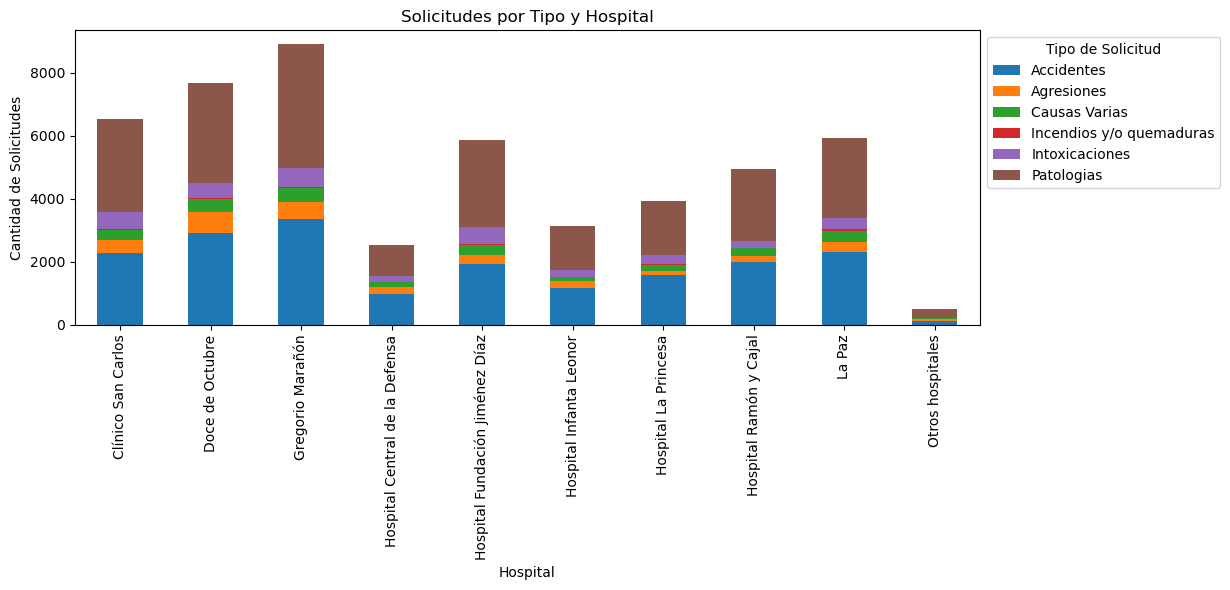

In [11]:
#Urgencias más comunes por hospital

#sol_por_hosp=data.groupby('Hospital') ['Tipo_de_solicitud'].count()
#sol=data.groupby(['Hospital', 'Tipo_de_solicitud']).size()
solicitudes_por_hospital=data.groupby(['Hospitales','Tipo_de_solicitud']).size().unstack()
solicitudes_por_hospital.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Hospital')
plt.ylabel('Cantidad de Solicitudes')
plt.title('Solicitudes por Tipo y Hospital')
plt.legend(title='Tipo de Solicitud', bbox_to_anchor=(1, 1))
plt.tight_layout()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 [Text(0, 0, 'CENTRO'),
  Text(1, 0, 'CARABANCHEL'),
  Text(2, 0, 'VALLECAS PTE.'),
  Text(3, 0, 'LATINA'),
  Text(4, 0, 'MONCLOA'),
  Text(5, 0, 'TETUAN'),
  Text(6, 0, 'SALAMANCA'),
  Text(7, 0, 'ARGANZUELA'),
  Text(8, 0, 'FUENCARRAL'),
  Text(9, 0, 'CHAMBERI'),
  Text(10, 0, 'CIUDAD LINEAL'),
  Text(11, 0, 'CHAMARTIN'),
  Text(12, 0, 'USERA'),
  Text(13, 0, 'SAN BLAS'),
  Text(14, 0, 'RETIRO'),
  Text(15, 0, 'VILLAVERDE'),
  Text(16, 0, 'HORTALEZA'),
  Text(17, 0, 'VILLA DE VALLECAS'),
  Text(18, 0, 'MORATALAZ'),
  Text(19, 0, 'VICALVARO'),
  Text(20, 0, 'BARAJAS')])

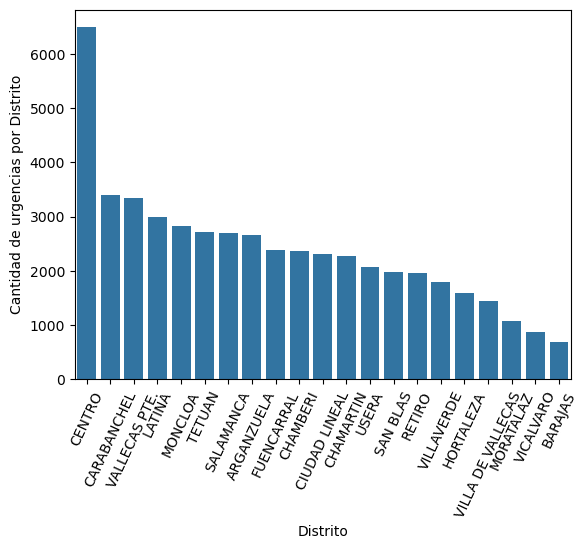

In [12]:
#Graficando la cantidad de urgencias por distrito
sns.barplot(data=data['Distrito'].value_counts())
plt.ylabel('Cantidad de urgencias por Distrito')
plt.xticks(rotation=65)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'La Paz'),
  Text(1, 0, 'Hospital Fundación Jiménez Díaz'),
  Text(2, 0, 'Doce de Octubre'),
  Text(3, 0, 'Clínico San Carlos'),
  Text(4, 0, 'Hospital Central de la Defensa'),
  Text(5, 0, 'Hospital La Princesa'),
  Text(6, 0, 'Gregorio Marañón'),
  Text(7, 0, 'Hospital Infanta Leonor'),
  Text(8, 0, 'Hospital Ramón y Cajal'),
  Text(9, 0, 'Otros hospitales')])

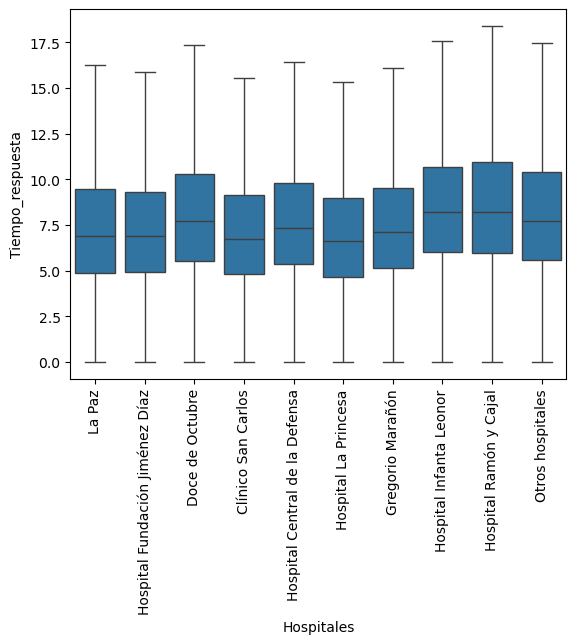

In [13]:
#Graficando el tiempo de respuesta a las solicitudes por hospital
sns.boxplot(data=data, x='Hospitales', y='Tiempo_respuesta',showfliers=False)
plt.xticks(rotation='vertical')

<Axes: xlabel='Densidad', ylabel='Hospitales'>

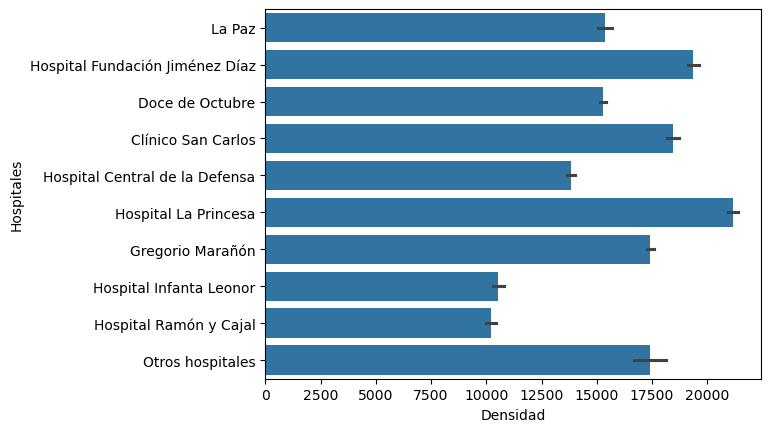

In [14]:
#Relación entre la variable Hospitales y Densidad
sns.barplot(data, y="Hospitales", x='Densidad', errorbar=('ci', 95), orient='h', estimator='mean')

<Axes: xlabel='Superficie', ylabel='Hospitales'>

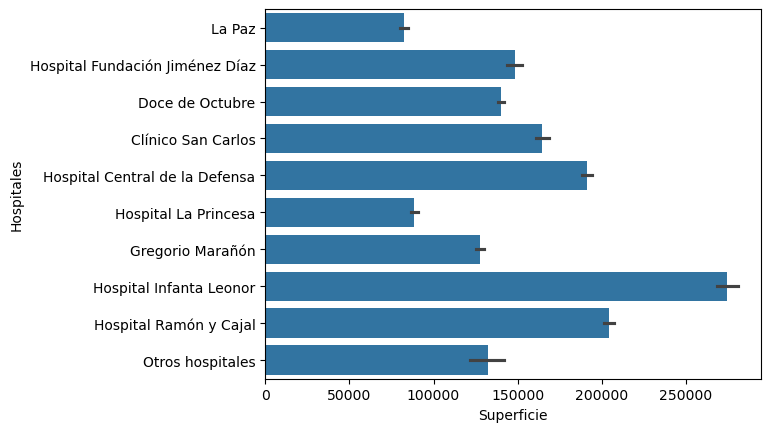

In [15]:
#Graficando la cantidad de solicitudes que reciben los hospitales en función de la variable Superficie
sns.barplot(data, y="Hospitales", x='Superficie', errorbar=('ci', 95), orient='h', estimator='mean')

<Axes: xlabel='Poblacion', ylabel='Hospitales'>

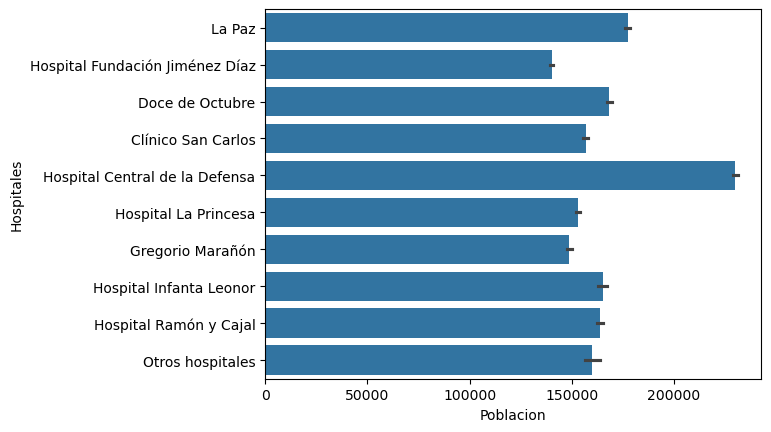

In [16]:
#Visualizando la relación entre la variable Hospitales y la variable Población
sns.barplot(data, y="Hospitales", x='Poblacion', errorbar=('ci', 95), orient='h', estimator='mean')

<Axes: xlabel='lat', ylabel='Hospitales'>

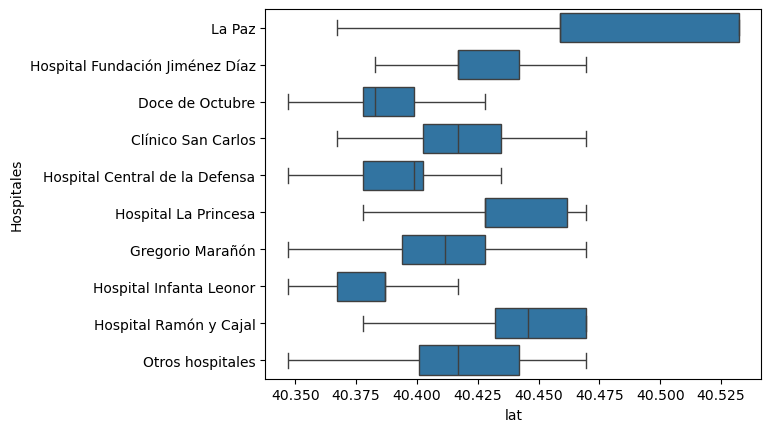

In [17]:
#Visualizando la cantidad de emergencias que reciben los hospitales según la latitud
#Identificar los datos atipicos para el momento de la división de los datos en train y test
sns.boxplot(data=data, x='lat', y='Hospitales',showfliers=False)

<Axes: xlabel='lon', ylabel='Hospitales'>

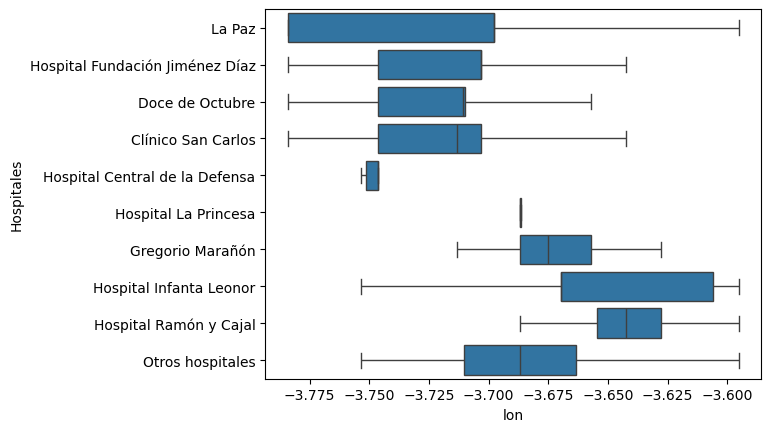

In [18]:
#Graficando la cantidad de emergencias por hospital y longitud
sns.boxplot(data=data, x='lon', y='Hospitales',showfliers=False)

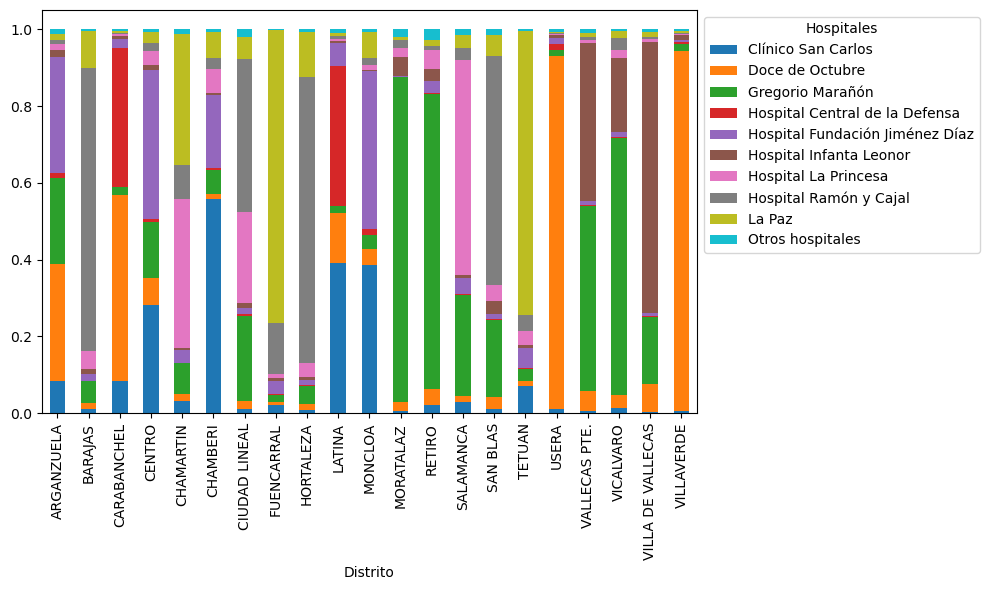

In [19]:
#Graficando la frecuencia relativa de las emergencias recibidas en los hospitales por cada distrito
#se puedee observar en que hospital comunmente se atienden las emergencias de cada distrito
pd.crosstab(data.Distrito , data.Hospitales , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Hospitales', bbox_to_anchor=(1, 1))
plt.tight_layout()

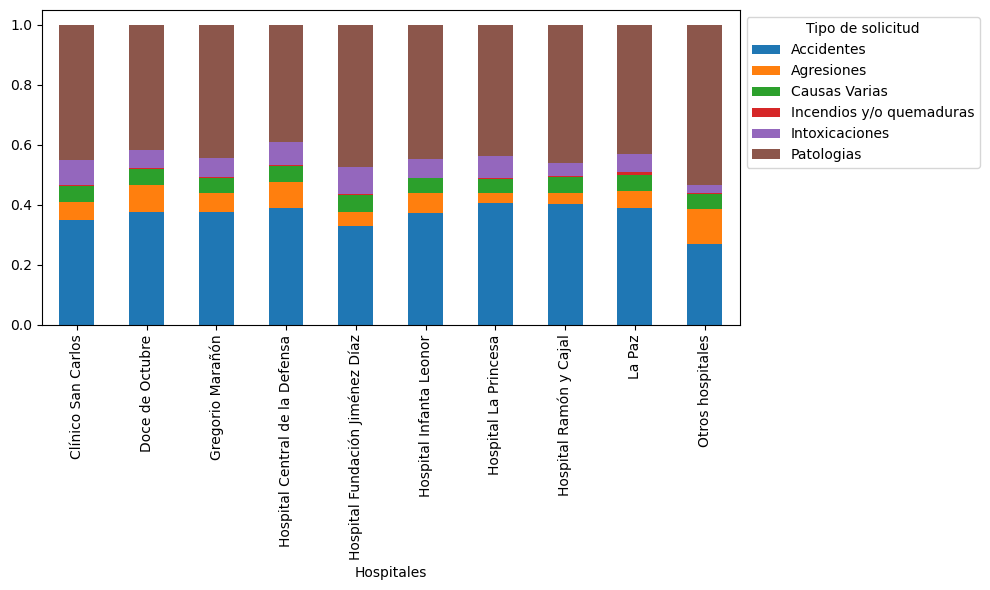

In [20]:
#Graficando la frecuencia relativa de las emergencias que atienden los hospitales según el tipo
pd.crosstab(data.Hospitales , data.Tipo_de_solicitud , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Tipo de solicitud', bbox_to_anchor=(1, 1))
plt.tight_layout()

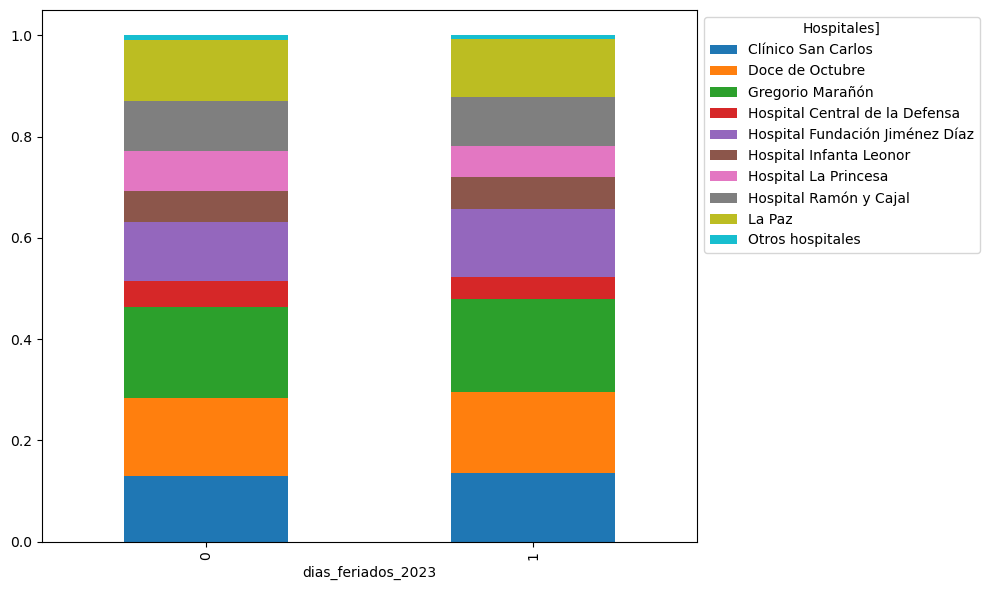

In [21]:
#Graficando la frecuencia relativa de la cantidad de emergencias atendidas en los hopitales en los días festivos
pd.crosstab(data.dias_feriados_2023 , data.Hospitales , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Hospitales]', bbox_to_anchor=(1, 1))
plt.tight_layout()

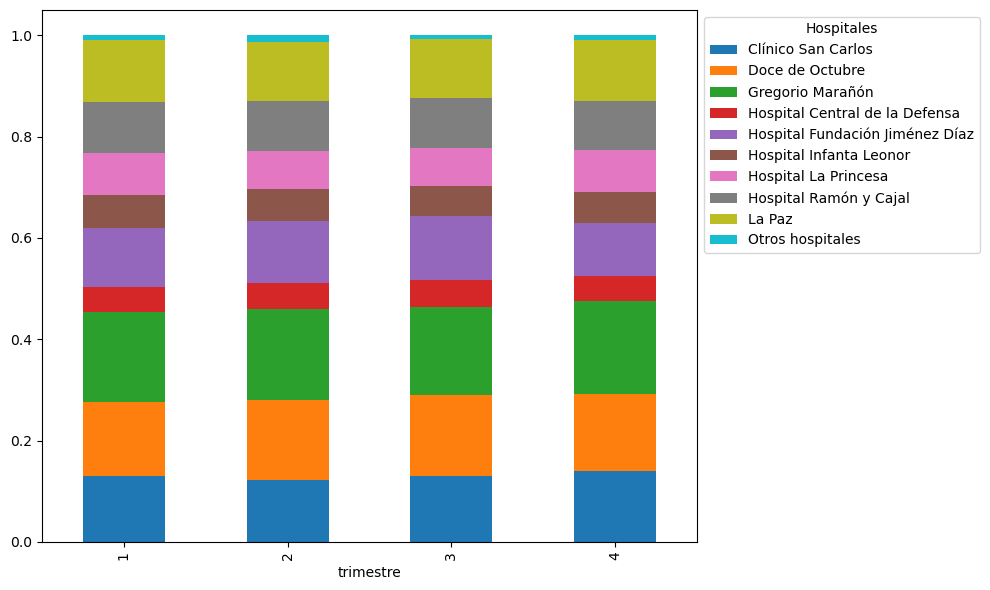

In [22]:
#Graficando la frecuencia relativa de la cantidad de emergencias atendidas en los hopitales por trimestre
pd.crosstab(data.trimestre , data.Hospitales , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Hospitales', bbox_to_anchor=(1, 1))
plt.tight_layout()

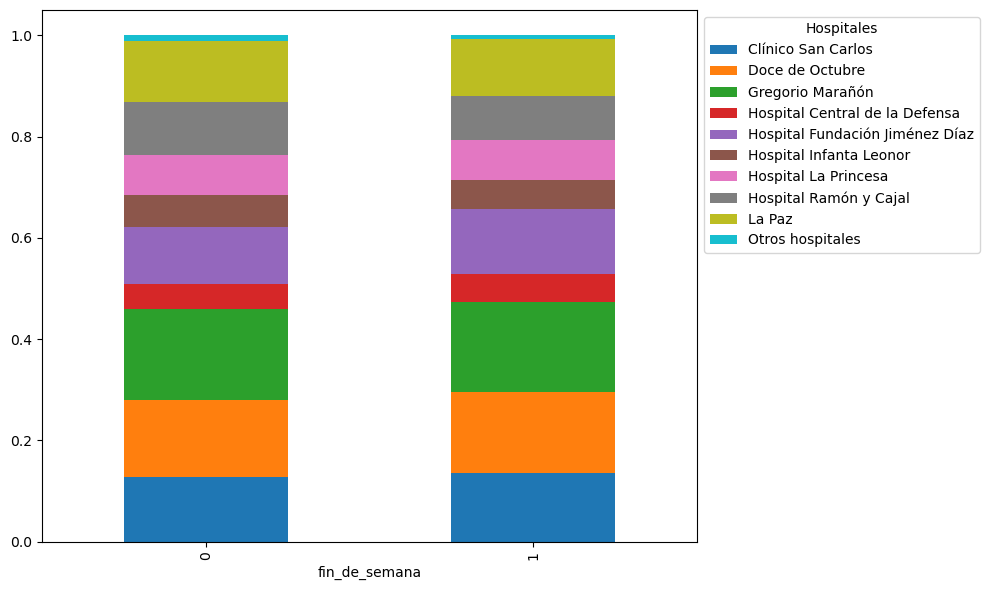

In [23]:
##Graficando la frecuencia relativa de la cantidad de emergencias atendidas en los hopitales los fines de semana
pd.crosstab(data.fin_de_semana , data.Hospitales , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Hospitales', bbox_to_anchor=(1, 1))
plt.tight_layout()

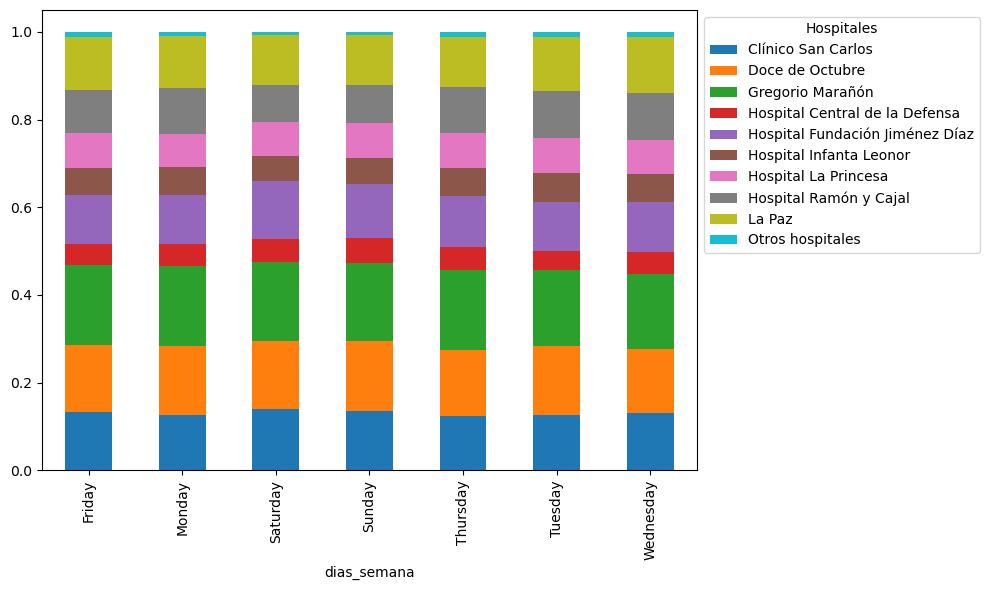

In [24]:
#Graficando la frecuencia relativa de la cantidad de emergencias atendidas en los hopitales según el día de la semana
pd.crosstab(data.dias_semana , data.Hospitales , normalize='index').plot(kind='bar', stacked=True, figsize=(10,6))
plt.legend(title= 'Hospitales', bbox_to_anchor=(1, 1))
plt.tight_layout()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'La Paz'),
  Text(1, 0, 'Hospital Fundación Jiménez Díaz'),
  Text(2, 0, 'Doce de Octubre'),
  Text(3, 0, 'Clínico San Carlos'),
  Text(4, 0, 'Hospital Central de la Defensa'),
  Text(5, 0, 'Hospital La Princesa'),
  Text(6, 0, 'Gregorio Marañón'),
  Text(7, 0, 'Hospital Infanta Leonor'),
  Text(8, 0, 'Hospital Ramón y Cajal'),
  Text(9, 0, 'Otros hospitales')])

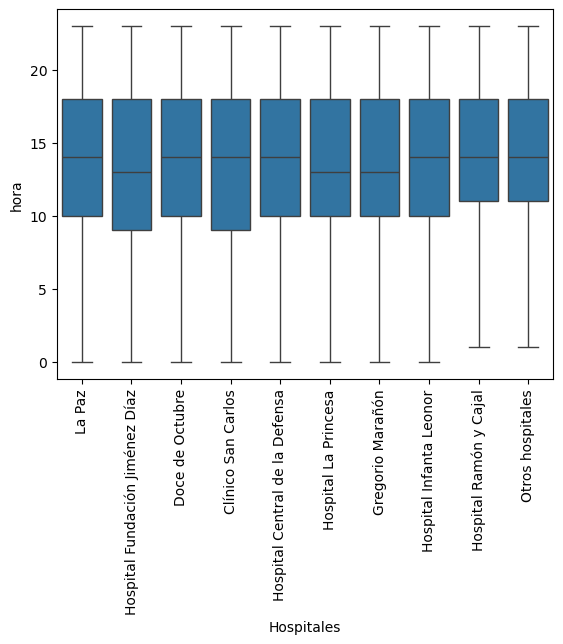

In [25]:
#Mostrando la relación de la cantidad de solicitudes que reciben los hospitales por hora
sns.boxplot(data=data, x='Hospitales', y='hora',showfliers=False)
plt.xticks(rotation=90)

# Entrenamiento del modelo

In [26]:
#Limpiando el Dataframe para solo trabajar con las variables que tienen relación o que pueden explicar la variable dependiente
data= data[['Hospitales','Densidad','lat','lon','Tiempo_respuesta','Distrito','Tipo_de_solicitud']]

#Conviertiendo las variables categóricas a numéricas
data=pd.get_dummies (data, columns= ['Tipo_de_solicitud','Distrito'],dtype=int)


In [33]:
#Dividiendo la data en training y test

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import top_k_accuracy_score

X = data.drop('Hospitales', axis = 1)
y = data['Hospitales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify = y, random_state=42)

In [34]:
#Entrenando un modelo de árbol de decisión
arbol= DecisionTreeClassifier(criterion= 'entropy', max_depth= 5, min_samples_leaf= 50, min_samples_split= 10, random_state=42)

'''
params={'max_depth': [3,5,6],
        'min_samples_split':[10,15,25,30,50],
        'criterion': ['entropy'],
        'min_samples_leaf':[25,30,50,60,80]}

grid_arbol= GridSearchCV(estimator=arbol,
                       param_grid=params,
                        cv=3,
                       scoring='accuracy',
                       verbose=1,
                       n_jobs=-1)
grid_arbol.fit(X_train, y_train)
'''
arbol.fit(X_train, y_train)
print(top_k_accuracy_score(y_test, arbol.predict_proba(X_test), k=9))
print(arbol.score(X_train, y_train))
print(arbol.score(X_test, y_test))


0.9953938584779706
0.5568939372264027
0.5638851802403204


In [ ]:
#Entrenando un modelo RandomForest
from sklearn.ensemble import RandomForestClassifier

bosque=RandomForestClassifier(criterion= 'entropy',max_depth= 7, min_samples_leaf= 30, min_samples_split = 10, n_estimators= 25,random_state=42)

'''
params_bosque={'max_depth': [5,6,7],
               'n_estimators':[10,25,50,60],
        'min_samples_split':[10,15,25,30,50],
        'criterion': ['entropy'],
        'min_samples_leaf':[25,30,50,60,80]}

bosque= GridSearchCV(estimator=bosque,
                       param_grid=params_bosque,
                        cv=3,
                       scoring='accuracy',
                       verbose=1,
                       n_jobs=-1)
'''

bosque.fit(X_train, y_train)
print(top_k_accuracy_score(y_test, bosque.predict_proba(X_test), k=2))
print(bosque.score(X_train, y_train))
print(bosque.score(X_test, y_test))



Fitting 3 folds for each of 300 candidates, totalling 900 fits
0.7934579439252336
0.5586964607593488
0.559679572763685


In [39]:
bosque.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 30,
 'min_samples_split': 10,
 'n_estimators': 25}

In [40]:
print(top_k_accuracy_score(y_test, bosque.predict_proba(X_test), k=2))
print(bosque.score(X_train, y_train))
print(bosque.score(X_test, y_test))


0.7934579439252336
0.5586964607593488
0.559679572763685


In [45]:
#Entrenando un modelo Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

boost=GradientBoostingClassifier(learning_rate= 0.08, max_depth=3, n_estimators= 100, random_state=1)

'''
params_boost={'max_depth': [3,5,6],
              'learning_rate': [0.08,0.1,0.3],
               'n_estimators':[100,150,200,300]}

boost= GridSearchCV(estimator=boost,
                       param_grid=params_boost,
                        cv=3,
                       scoring='accuracy',
                       verbose=1,
                       n_jobs=-1)
'''
boost.fit(X_train, y_train)
print(boost.score(X_test, y_test))
print(boost.score(X_train, y_train))
print(top_k_accuracy_score(y_test, boost.predict_proba(X_test), k=2))

0.5628838451268358
0.5745472232554147
0.795260347129506


In [42]:
print(boost.score(X_test, y_test))
print(boost.score(X_train, y_train))
print(top_k_accuracy_score(y_test, boost.predict_proba(X_test), k=2))

0.5628838451268358
0.5745472232554147
0.795260347129506


In [ ]:
boost.best_params_

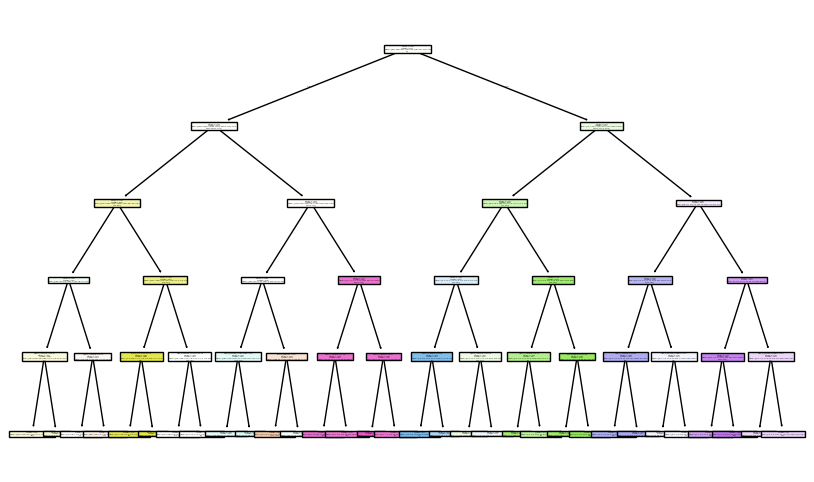

In [46]:
#Imprimiendo el árbol creado
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(10, 6))
plot_tree(arbol, filled=True, feature_names=X.columns)
plt.show()
